## imports

In [1]:
# pyqubo stuff
from pyqubo import Array, Constraint, Placeholder, solve_qubo
from mpl_toolkits.mplot3d import Axes3D

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import neal

## Constants

In [2]:
SQUARE_SIZE = 2
BITS = SQUARE_SIZE * SQUARE_SIZE

In [3]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## Magic Square Implementation

$$S_{\text{row=i}} = \sum_{j=1}^{n}\left[\sum_{k=1}^{s}x_{i,j,k}\right]$$


$$P_{\text{row}} = \sum_{i1>i2}^{n}\left[\sum_{j=1}^{n}\sum_{k=1}^{s}x_{i2,j,k} - \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i1,j,k}\right]^2$$

In [4]:
def implement_row(H, variables, penalty):
    """Ensure the all rows sum to the magic constant

    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """
    for i1 in range(SQUARE_SIZE):
        for i2 in range(i1+1, SQUARE_SIZE):

            H_tmp = 0
            
            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i1, j, k)], label=f"column_{i2}_{j}_{k}")

            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i2, j, k)], label=f"column_{i1}_{j}_{k}")

            H_tmp **= 2

            H += H_tmp

    H *= penalty
    
    return H

$$S_{\text{col=j}} = \sum_{i=1}^{n}\left[\sum_{k=1}^{s}x_{i,j,k}\right]$$


$$P_{\text{col}} = \sum_{j1>j2}^{n}\left[\sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j2,k} - \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j1,k}\right]^2$$

In [5]:
def implement_col(H, variables, penalty=1):
    """Aim is to ensure all columns sum to the magic constant

    
    Args:
        variables (_type_): _description_
        penalty (_type_): _description_
    """

    for j1 in range(SQUARE_SIZE):
        for j2 in range(j1+1, SQUARE_SIZE):

            H_tmp = 0
            
            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i, j2, k)], label=f"column_{i}_{j2}_{k}")

            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i, j1, k)], label=f"column_{i}_{j1}_{k}")

            H_tmp **= 2

            H += H_tmp

    H *= penalty
    
    return H

In [6]:
def implement_diag(H, variables, penalty):
    pass

In [7]:
def penalty_hamming(H, variables, penalty=1):
    """
    
    $$P_{\text{unique}} = \sum_{k=1}^{s}\left[\sum_{i1>i2}^{n}\sum_{j1>j2}^{n}(x_{i1,j1,k} - x_{i2,j2,k})^2\right]$$

    Args:
        H (_type_): _description_
        variables (_type_): _description_
        penalty (_type_): _description_
    """
    for k in range(BITS):
        for i1 in range(SQUARE_SIZE):
            for j1 in range(SQUARE_SIZE):
                for i2 in range(i1+1, SQUARE_SIZE):
                    for j2 in range(j1+1, SQUARE_SIZE):
                        
                        # if i1 > i2 and j2 > j1:
                        H += Constraint(penalty * (variables[get_index(i1, j1, k)] - variables[get_index(i2, j2, k)]) ** 2, label="hamming")
                        
    return H



def penalty_similar_hamming(H, variables, penalty):
    """
    
    $$P_{\text{unique}} = \sum_{k=1}^{s}\left[\sum_{i1>i2}^{n}\sum_{j1>j2}^{n}(x_{i1,j1,k} * x_{i2,j2,k})\right]^2$$

    Args:
        H (_type_): _description_
        variables (_type_): _description_
        penalty (_type_): _description_
    """

    
    for k in range(BITS):
        H_tmp = 0
        
        for i1 in range(SQUARE_SIZE):
            for j1 in range(SQUARE_SIZE):
                for i2 in range(i1+1, SQUARE_SIZE):
                    for j2 in range(j1+1, SQUARE_SIZE):
                        H_tmp += Constraint(penalty * variables[get_index(i1, j1, k)] * variables[get_index(i2, j2, k)], label="overlap")  

        H += H_tmp ** 2
                        
                        
    return H

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_12974/3593584608.py:2: SyntaxWarning: invalid escape sequence '\s'
  """
/tmp/ipykernel_12974/3593584608.py:25: SyntaxWarning: invalid escape sequence '\s'
  """


$$\sum_{i=1}^{n}\sum_{j=1}^{n}\left[\prod_{k=1}^{s}1 - (x_{i,j,k} \oplus 0)\right]$$

In [8]:
def penalty_empty(H, variables, penalty=1):

    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)

    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
                H += Constraint(penalty * np.prod([1 - xor(var, 0) for var in list(variables)[get_index(i,j,0):get_index(i,j,BITS)]]), label=f"empty_{i}_{j}")

    return H
                

$$\sum_{i1,j1<i2,j2}^n\left[\sum_{k=1}^{n}{x_{i2,j2,k}} - \sum_{k=1}^{s}{x_{i1,j1,k}}\right]^2$$

In [34]:
def penalty_unique(H, variables, penalty):
    """Aim is to make sure the each number in the magic square is unique

    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """

    for i1 in range(SQUARE_SIZE):
        for j1 in range(SQUARE_SIZE):
            for i2 in range(i1, SQUARE_SIZE):
                for j2 in range(SQUARE_SIZE):

                    H_tmp = 0
                    
                    if i1 == i2 and j1 <= j2:
                        continue

                    for k in range(BITS):
                        H_tmp += variables[get_index(i1, j1, k)]

                    for k in range(BITS):
                        H_tmp -= variables[get_index(i2, j2, k)]

                    H_tmp **= 2
                    H += Constraint(H_tmp, label=f"unique_{i1}_{j1}_{i2}_{j2}")

    return -1 * penalty * H

## Construct QUBO

In [10]:
def comb(variables):
    """A utils function for generating unique combinations of variables

    Args:
        variables (_type_): _description_
    """

    return sum([variables[i] * variables[j] for i in range(len(variables)) for j in range(i+1, len(variables))])

## Formulate & Display QUBO

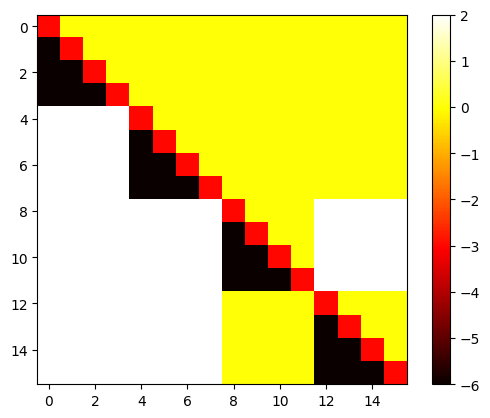

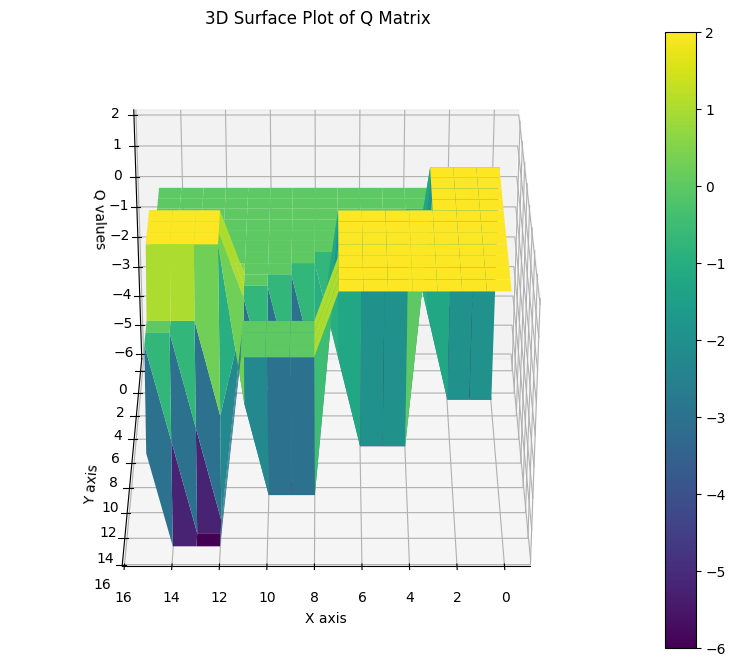

In [35]:
array = Array.create('x', SQUARE_SIZE * SQUARE_SIZE * BITS, 'BINARY')

# apply constraints
H = 0
# H += penalty_hamming(H, array, 1)
# H += penalty_similar_hamming(H, array, 1)
H += penalty_unique(H, array, 1)
# H += penalty_empty(H, array, 1)
# H += implement_col(H, array, 1)
# H += implement_row(H, array, 1)


model = H.compile()
qubo, offset = model.to_qubo()

Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

for key, value in qubo.items():
    i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
    j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

    Q[i][j] = value

plt.imshow(Q, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Create a meshgrid for the indices of the Q matrix
x = np.arange(Q.shape[0])
y = np.arange(Q.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Q, cmap='viridis')

fig.colorbar(surf)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Q values')

# Set title
ax.set_title('3D Surface Plot of Q Matrix')
ax.view_init(elev=30, azim=90)

plt.show()

## Perform Annealing

In [36]:
# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=5000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy
    
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    # split the sample values into bit sized chunks
    # sample = np.array([list(sample.values())[i:i+BITS] for i in range(0, len(sample), BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))

    solutions.append({"sample": sample, "energy": energy})

## Analyse

In [37]:
def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            grid[i][j] = sum(item)
                
    return np.array(grid)

def check_unique(sample):

    grid = get_grid(sample).flatten()
    return len(set(grid)) == len(grid)


def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

error = 0
unique = 0
sumcol = 0
sumrow = 0

for solution in solutions:    
    # if 1 not in get_grid(solution["sample"]).flatten():
    #     error += 1
    #     continue

    if check_unique(solution["sample"]):
        unique += 1

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1

print(f"No 1's: {error}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")

No 1's: 0/5000
Unique Correct: 0/5000
Sum Column Correct: 3347/5000
Sum Row Correct: 3326/5000


## Show Examples

In [38]:

def to_decimal(array):
        return sum(array)


def get_grid(sample):
    
        
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])

            
            if 1 in item:

                ## convert binary value to decimal
                grid[i][j] = to_decimal(item)
            else:
                grid[i][j] = -1
    return np.array(grid)


def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)


for key, value in condensed.items():
    print(key)
    print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
    print(value)
    print("\n\n")

[0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
[[-1.  4.]
 [-1.  4.]]
{'count': 829, 'energy': -64.0}



[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
[[-1.  4.]
 [ 4. -1.]]
{'count': 827, 'energy': -64.0}



[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[[-1. -1.]
 [ 4.  4.]]
{'count': 833, 'energy': -64.0}



[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[[ 4.  4.]
 [-1. -1.]]
{'count': 841, 'energy': -64.0}



[1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
[[ 4. -1.]
 [-1.  4.]]
{'count': 846, 'energy': -64.0}



[1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0]
[[ 4. -1.]
 [ 4. -1.]]
{'count': 824, 'energy': -64.0}





## quick experiment for uniqueness

In [253]:
results = {}

for alpha in range(1, 10):
    for beta in range(1, 10):
        for gamma in range(1, 10):
            print(f"performing alpha: {alpha}, beta: {beta}, gamma: {gamma}")
            array = Array.create('x', SQUARE_SIZE * SQUARE_SIZE * BITS, 'BINARY')

            # apply constraints
            H = 0

            H += penalty_hamming(H, array, alpha)
            H += penalty_similar_hamming(H, array, beta)
            H += penalty_empty(H, array, gamma)
            # H += implement_col(H, array, 1)
            # H += implement_row(H, array, 1)

            # compile and convert to binary quadratic model
            model = H.compile()
            bqm = model.to_bqm()

            # simulate
            sa = neal.SimulatedAnnealingSampler()
            sampleset = sa.sample(bqm, num_reads=5000)
            decoded_samples = model.decode_sampleset(sampleset)

            # decode
            solutions = []

            for solution in decoded_samples:
                
                # get the sample and energy
                sample = solution.sample
                energy = solution.energy

                # split the sample values into bit sized chunks
                sample = np.array([list(sample.values())[i:i+BITS] for i in range(0, len(sample), BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))

                solutions.append({"sample": sample, "energy": energy})

            error = 0
            unique = 0
            sumcol = 0
            sumrow = 0

            

            for solution in solutions:    
                if 0 in get_grid(solution["sample"]).flatten():
                    error += 1
                    continue

                if check_unique(solution["sample"]):
                    unique += 1

                if check_sum_col(solution["sample"]):
                    sumcol += 1

                if check_sum_row(solution["sample"]):
                    sumrow += 1

            results.setdefault((alpha, beta, gamma), {"error": error, "unique": unique, "sumcol": sumcol, "sumrow": sumrow})

performing alpha: 1, beta: 1, gamma: 1
performing alpha: 1, beta: 1, gamma: 2
performing alpha: 1, beta: 1, gamma: 3
performing alpha: 1, beta: 1, gamma: 4
performing alpha: 1, beta: 1, gamma: 5
performing alpha: 1, beta: 1, gamma: 6
performing alpha: 1, beta: 1, gamma: 7
performing alpha: 1, beta: 1, gamma: 8
performing alpha: 1, beta: 1, gamma: 9
performing alpha: 1, beta: 2, gamma: 1
performing alpha: 1, beta: 2, gamma: 2
performing alpha: 1, beta: 2, gamma: 3
performing alpha: 1, beta: 2, gamma: 4
performing alpha: 1, beta: 2, gamma: 5
performing alpha: 1, beta: 2, gamma: 6
performing alpha: 1, beta: 2, gamma: 7
performing alpha: 1, beta: 2, gamma: 8
performing alpha: 1, beta: 2, gamma: 9
performing alpha: 1, beta: 3, gamma: 1
performing alpha: 1, beta: 3, gamma: 2
performing alpha: 1, beta: 3, gamma: 3
performing alpha: 1, beta: 3, gamma: 4
performing alpha: 1, beta: 3, gamma: 5
performing alpha: 1, beta: 3, gamma: 6
performing alpha: 1, beta: 3, gamma: 7
performing alpha: 1, beta

In [252]:
results

{(0, 0, 0): {'error': 1155, 'unique': 166, 'sumcol': 848, 'sumrow': 822}}

## Plotting experiment

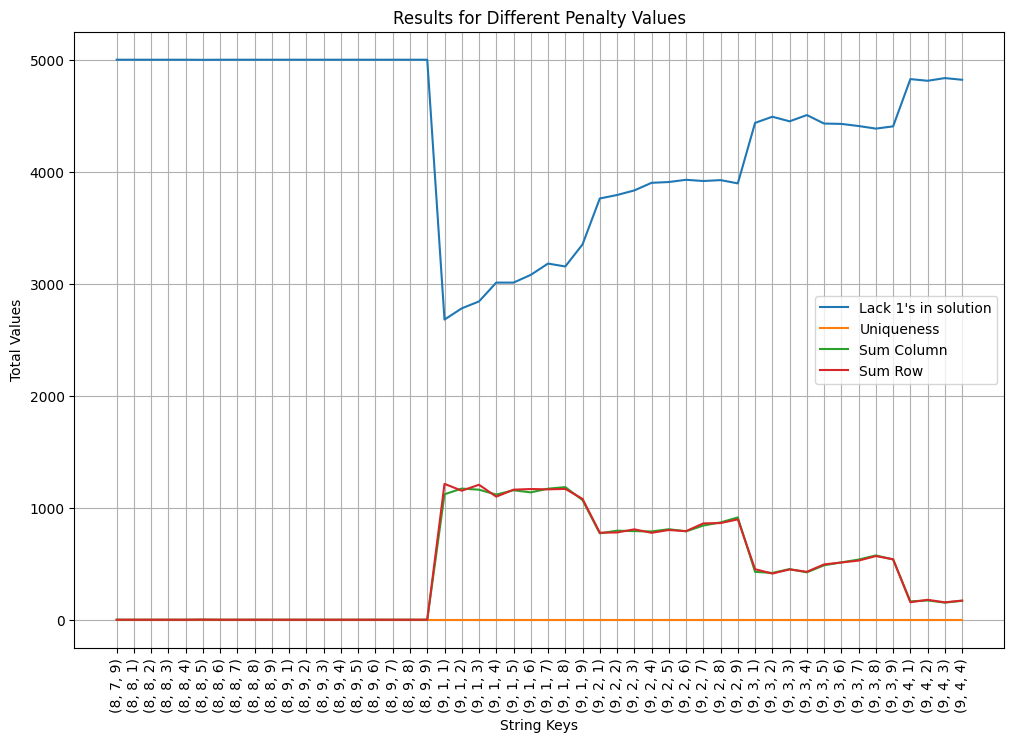

In [271]:
import matplotlib.pyplot as plt

# Extract the keys from the results dictionary
result_keys = list(results.keys())[-100:-50]
result_values = list(results.values())[-100:-50]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data

ax.plot([str(i) for i in result_keys], [i["error"] for i in result_values], label="Lack 1's in solution", markersize=8, markeredgecolor="black")
ax.plot([str(i) for i in result_keys], [i["unique"] for i in result_values], label="Uniqueness", markersize=8, markeredgecolor="black")
ax.plot([str(i) for i in result_keys], [i["sumcol"] for i in result_values], label="Sum Column", markersize=8, markeredgecolor="black")
ax.plot([str(i) for i in result_keys], [i["sumrow"] for i in result_values], label="Sum Row", markersize=8, markeredgecolor="black")


# Set labels and title
ax.set_xlabel('String Keys')
ax.set_ylabel('Total Values')
ax.set_title('Results for Different Penalty Values')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid()

# Show the plot
plt.show()